# Tutorial: Electrochemical Interfaces Simulation Accelerated by Machine Learning Potential

In [1]:
%%time
import os
import sys

pwd=os.getcwd()
sys.path.append(os.path.join(pwd, "scripts"))
import os

import anal
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from ase.io import read, write
from ase.visualize import view
from toolkit.analysis.analysis import Analysis
from toolkit.cp2k.cube import cube_pav
from toolkit.utils import au2eV

mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.size'] = 20


CPU times: user 982 ms, sys: 269 ms, total: 1.25 s
Wall time: 931 ms


## Cutoff Test for CP2K Labeling

In [2]:
%%time
! tree 00.cutoff_test -L 2

00.cutoff_test
├── cutoff_0300
│   ├── cp2k.lsf
│   ├── input.inp
│   ├── output_146324
│   └── xyz
├── cutoff_0400
│   ├── cp2k.lsf
│   ├── input.inp
│   ├── output_146325
│   └── xyz
├── cutoff_0500
│   ├── cp2k.lsf
│   ├── input.inp
│   ├── output_146329
│   └── xyz
├── cutoff_0600
│   ├── cp2k.lsf
│   ├── input.inp
│   ├── output_146331
│   └── xyz
├── cutoff_0700
│   ├── cp2k.lsf
│   ├── input.inp
│   ├── output_146333
│   └── xyz
├── cutoff_0800
│   ├── cp2k.lsf
│   ├── input.inp
│   ├── output_146336
│   └── xyz
├── cutoff_0900
│   ├── cp2k.lsf
│   ├── input.inp
│   ├── output_146337
│   └── xyz
├── cutoff_1000
│   ├── cp2k.lsf
│   ├── input.inp
│   ├── output_146342
│   └── xyz
├── cutoff_1100
│   ├── cp2k.lsf
│   ├── input.inp
│   ├── output_146343
│   └── xyz
└── cutoff_1200
    ├── cp2k.lsf
    ├── input.inp
    ├── output_146344
    └── xyz

10 directories, 40 files
CPU times: user 2.74 ms, sys: 8.82 ms, total: 11.6 ms
Wall time: 549 ms


In [3]:
%%time
anal.post_cp2k_cutoff_test(".", cutoff_lo=300, cutoff_hi=1200)

Energy Converge Result:
--------------------------------------------------
cutoff: 0400   -2.05699 meV/atom
cutoff: 0500   -0.65439 meV/atom
cutoff: 0600   -0.07256 meV/atom
cutoff: 0700   -0.06583 meV/atom
cutoff: 0800    0.01178 meV/atom
cutoff: 0900    0.01010 meV/atom
cutoff: 1000    0.00023 meV/atom
cutoff: 1100   -0.00021 meV/atom
cutoff: 1200   -0.00031 meV/atom
Force Converge Result:
--------------------------------------------------
cutoff: 0400 rmse:   117.0059 meV/A   max_error:   612.7433 meV/A
cutoff: 0500 rmse:    85.6640 meV/A   max_error:   324.5987 meV/A
cutoff: 0600 rmse:    56.6574 meV/A   max_error:   207.0427 meV/A
cutoff: 0700 rmse:    32.8073 meV/A   max_error:   134.7916 meV/A
cutoff: 0800 rmse:    17.2420 meV/A   max_error:    69.5221 meV/A
cutoff: 0900 rmse:     7.6215 meV/A   max_error:    39.0021 meV/A
cutoff: 1000 rmse:     4.1994 meV/A   max_error:    19.5234 meV/A
cutoff: 1100 rmse:     1.8545 meV/A   max_error:    10.8362 meV/A
cutoff: 1200 rmse:     0.8

## Prepare Training Set

In [4]:
%%time
! tree 01.init_data -L 2

01.init_data
├── set.000
│   ├── box.npy
│   ├── coord.npy
│   ├── energy.npy
│   └── force.npy
├── type_map.raw
└── type.raw

1 directory, 6 files
CPU times: user 4.71 ms, sys: 1.21 ms, total: 5.91 ms
Wall time: 546 ms


## Prepare MD Initial Strucutre

In [5]:
%%time
! tree 02.md_init_stcs -L 2

02.md_init_stcs
├── POSCAR_000
├── POSCAR_001
├── POSCAR_002
├── POSCAR_003
└── POSCAR_004

0 directories, 5 files
CPU times: user 2.55 ms, sys: 8.43 ms, total: 11 ms
Wall time: 119 ms


## Prepare DP-GEN-CP2K Template

In [6]:
%%time
with open("03.dpgen/template.inp") as fp:
    for line in fp.readlines():
        print(line, end="")

&FORCE_EVAL
  METHOD Quickstep
  &PRINT
    &FORCES ON
    &END FORCES  
  &END PRINT
  &DFT
    BASIS_SET_FILE_NAME BASIS_MOLOPT
    POTENTIAL_FILE_NAME GTH_POTENTIALS
    &MGRID
      CUTOFF 800
      NGRIDS 5
      REL_CUTOFF 60
    &END MGRID
    &QS
      EPS_DEFAULT 1.0E-13
      EXTRAPOLATION ASPC
      EXTRAPOLATION_ORDER 2
    &END QS
    &SCF
      EPS_SCF 1.0E-6
      MAX_SCF 50
      &OUTER_SCF
        EPS_SCF 1.0E-6
        MAX_SCF 10
      &END
      &OT
        MINIMIZER DIIS 
        PRECONDITIONER FULL_SINGLE_INVERSE
        ENERGY_GAP 0.1
      &END
    &END SCF
    &XC
      &XC_FUNCTIONAL PBE
      &END XC_FUNCTIONAL
      &XC_GRID
        XC_SMOOTH_RHO NN50
        XC_DERIV NN50_SMOOTH
      &END XC_GRID
      &vdW_POTENTIAL
        DISPERSION_FUNCTIONAL PAIR_POTENTIAL
        &PAIR_POTENTIAL
          TYPE DFTD3
          PARAMETER_FILE_NAME dftd3.dat
          REFERENCE_FUNCTIONAL PBE
          CALCULATE_C9_TERM TRUE
          REFERENCE_C9_TERM TRUE
        &END 

## Analysis the Model Deviation After DP-GEN

DPGEN Exploration for System 000 at 330K

--------------------------------------------------
iter.000000

accurate          :  98.90%
candidate         :   0.81%
failed            :   0.29%
Max Model Devi.   :   0.59 eV/A
iter.000001

accurate          :  99.99%
candidate         :   0.01%
failed            :   0.00%
Max Model Devi.   :   0.18 eV/A
iter.000002

accurate          : 100.00%
candidate         :   0.00%
failed            :   0.00%
Max Model Devi.   :   0.13 eV/A
DPGEN Exploration for System 000 at 430K

--------------------------------------------------
iter.000000

accurate          :  95.01%
candidate         :   3.72%
failed            :   1.27%
Max Model Devi.   :   0.77 eV/A
iter.000001

accurate          :  99.46%
candidate         :   0.54%
failed            :   0.00%
Max Model Devi.   :   0.20 eV/A
iter.000002

accurate          :  99.85%
candidate         :   0.15%
failed            :   0.00%
Max Model Devi.   :   0.22 eV/A
DPGEN Exploration for System 000 at 530K

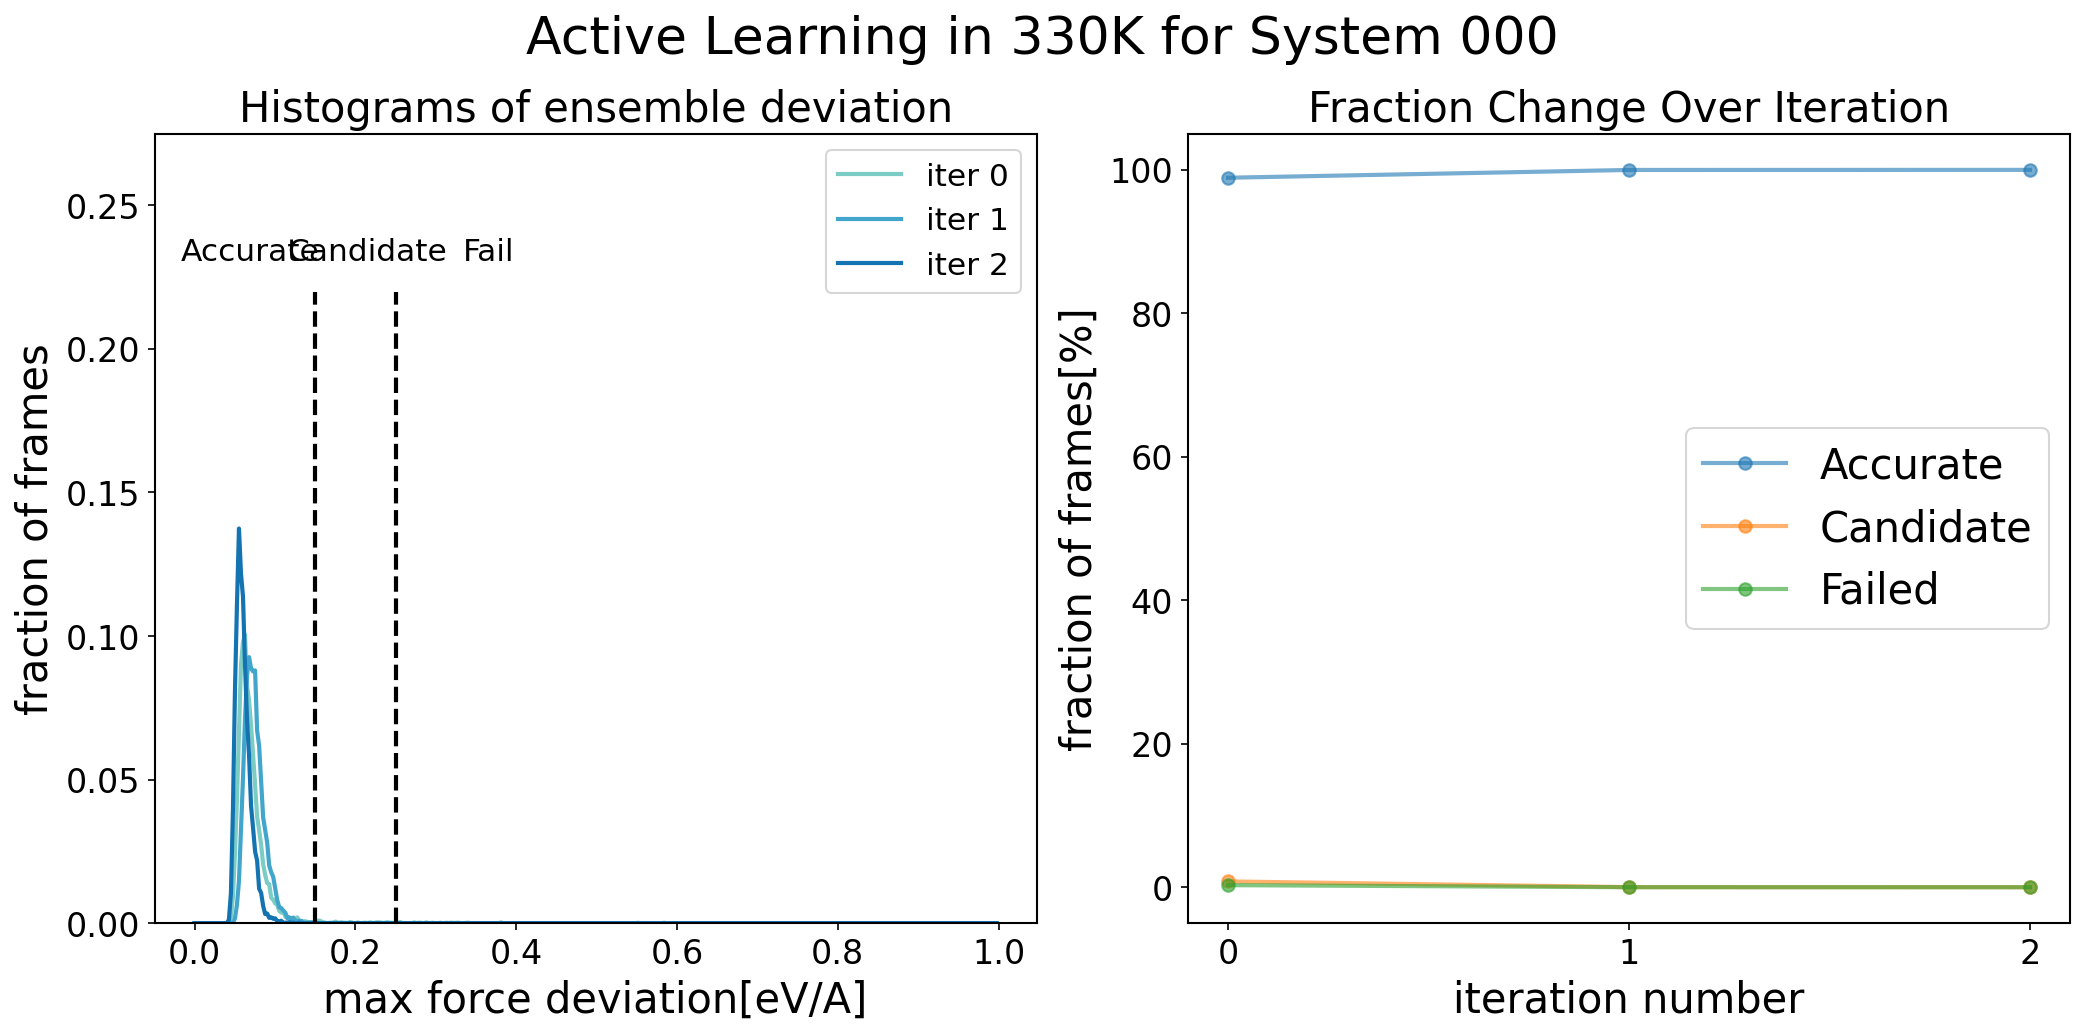

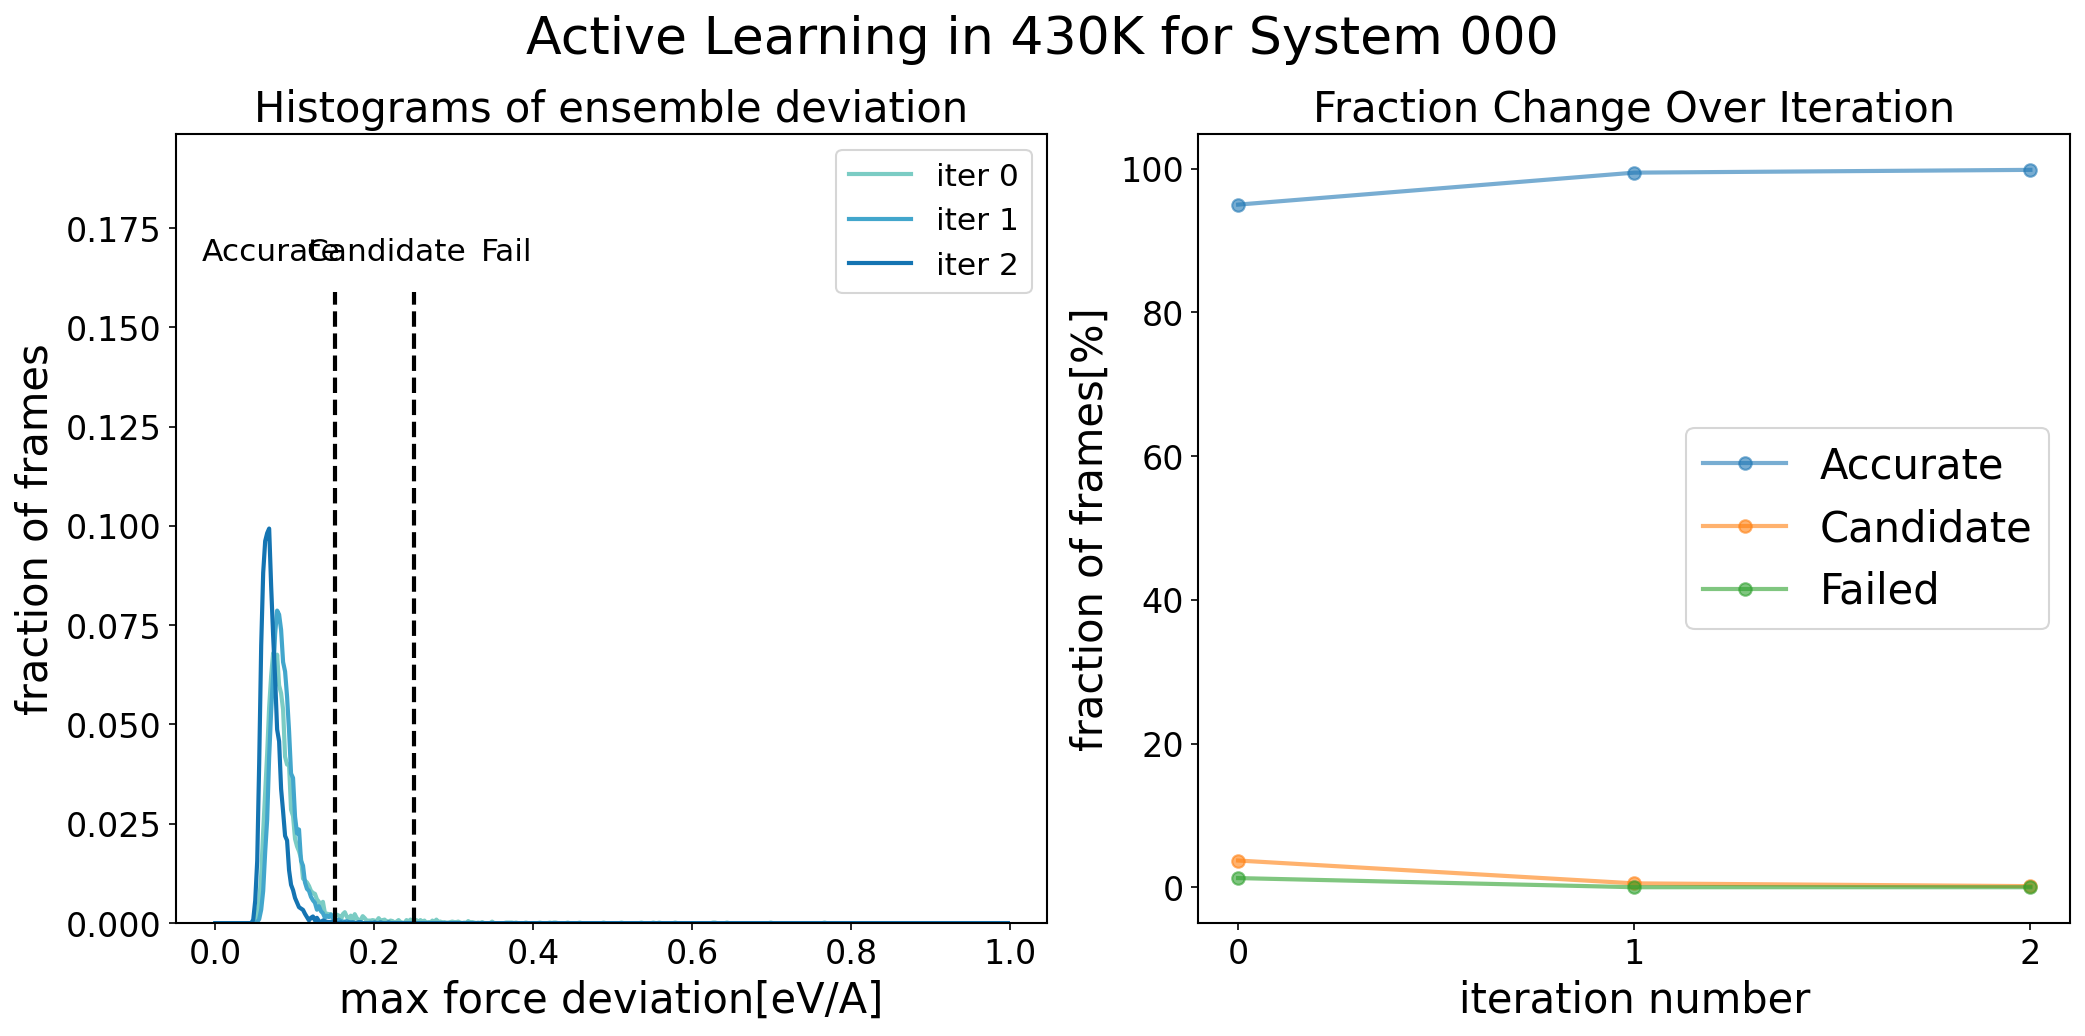

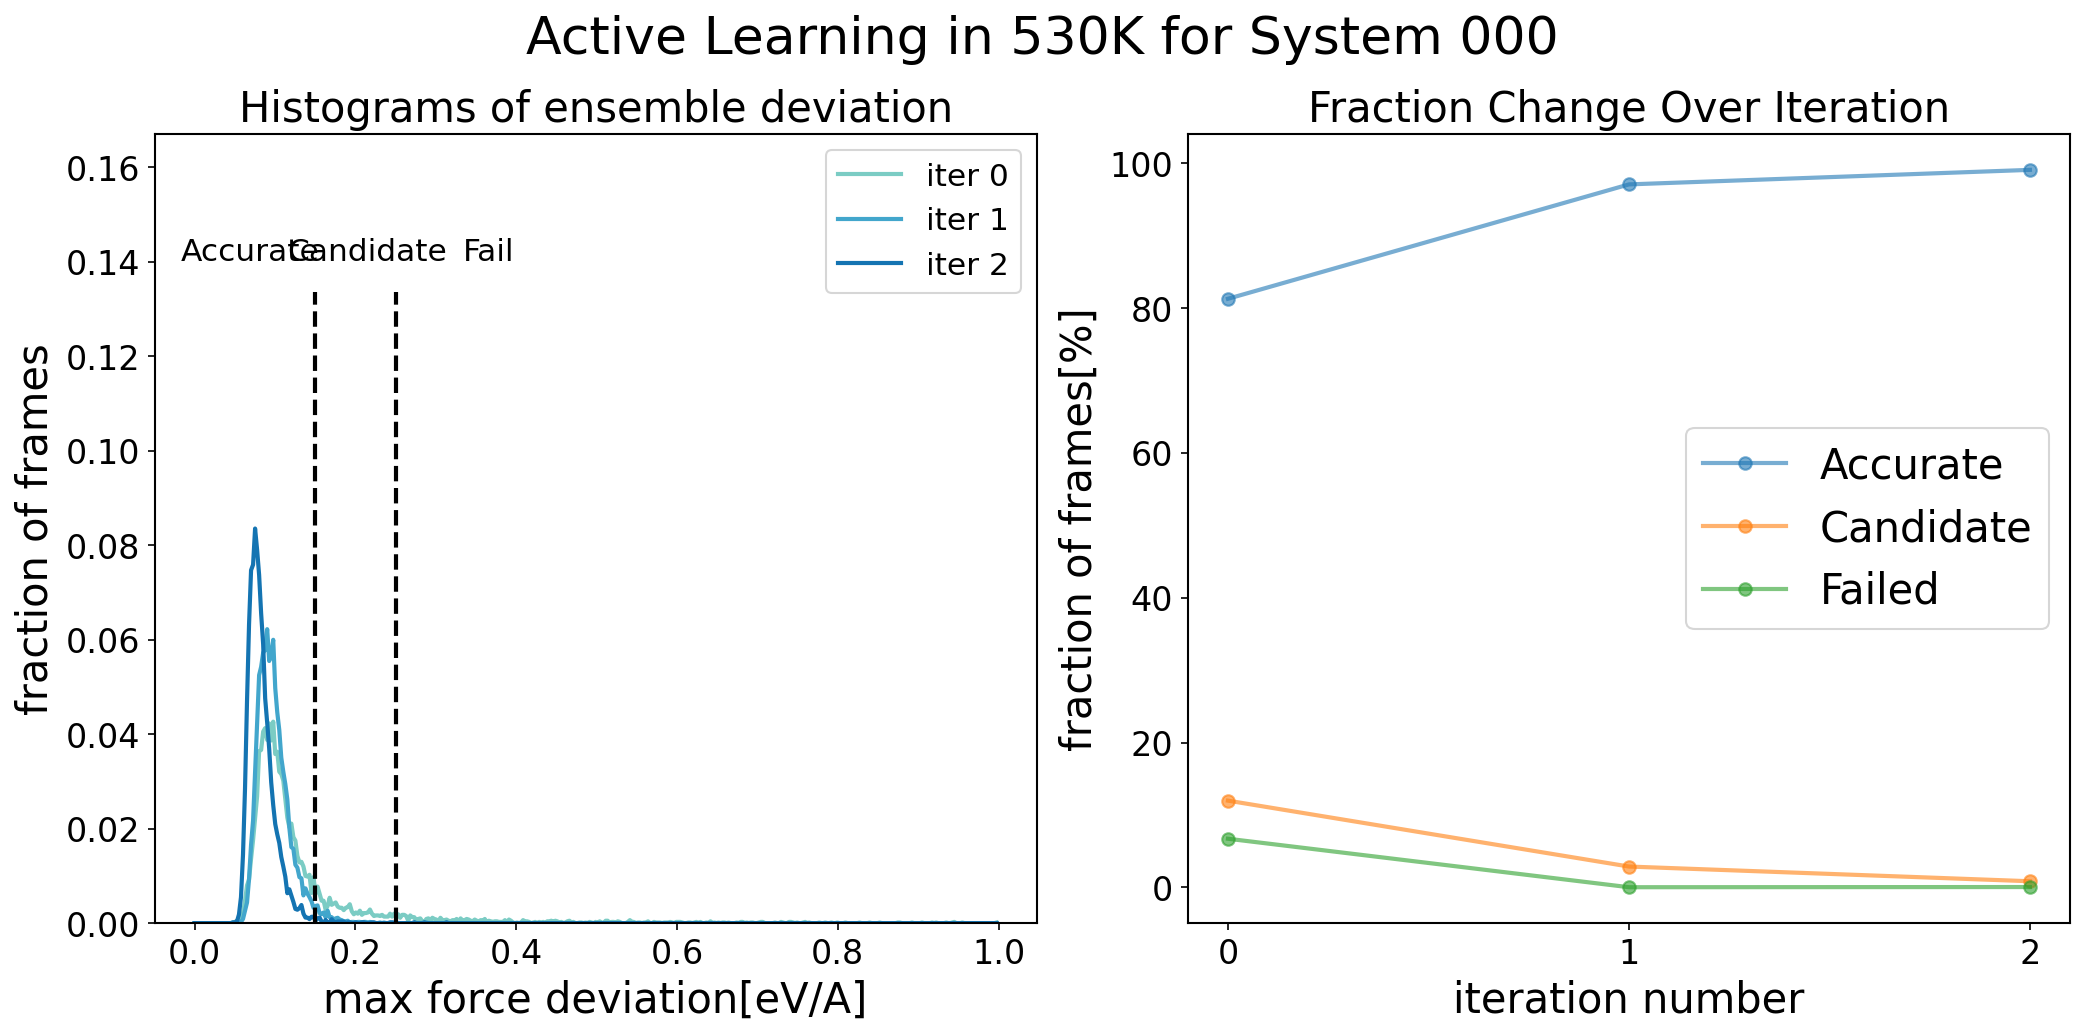

In [7]:
%%time
anal.plot_all_model_devi("05.all_model_devi", trust_lo=0.15, trust_hi=0.25, colormap='GnBu')

## Check Water Density

10.produnction/01.water_density_DPMD/shiftsno2-water-0.xyz
16
16
ToolKit: The following analysis will be performed
ToolKit: Function: O_density
ToolKit: Read Structure File: 10.produnction/01.water_density_DPMD/shiftsno2-water-0.xyz
ToolKit: Read the Cell Info: [12.745, 13.399, 40.985]
ToolKit: Read Surface 1 Atoms Index: [597, 602, 603, 605, 607, 614, 621, 626, 632, 634, 641, 649, 657, 665, 666, 667]
ToolKit: Read Surface 2 Atoms Index: [589, 591, 601, 615, 620, 622, 623, 627, 630, 631, 640, 643, 650, 651, 659, 668]
ToolKit: Now Start Reading Structures
ToolKit: ----------------------------
ToolKit: Reading Structures is Finished
ToolKit: Read Frame Number: 1001
ToolKit: Read Atom Number: 669
ToolKit: Use the Oxygen index from external input
ToolKit: Calculated Origin Water Center Position: 20.510659515484516 A
ToolKit: Water Center will shift to Cell Center: 20.4925 A
ToolKit: START GETTING OXYGEN DENSITY
ToolKit: ----------------------------
ToolKit: Oxygen Density Profile Data Save

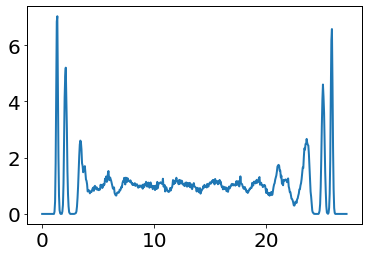

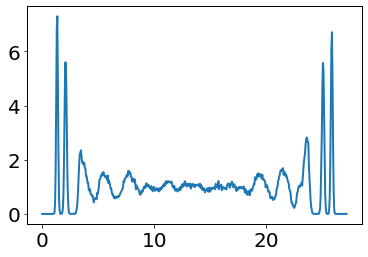

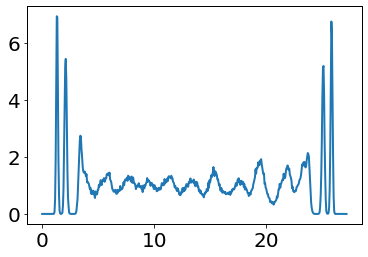

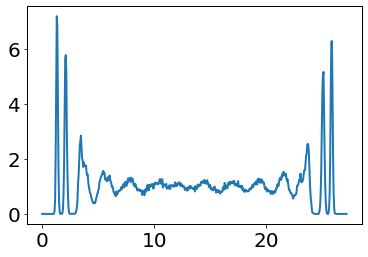

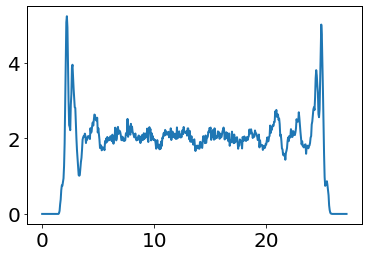

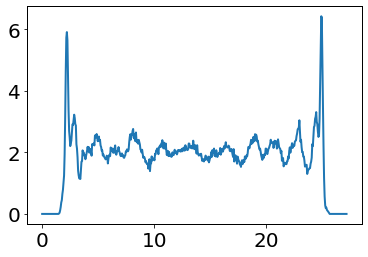

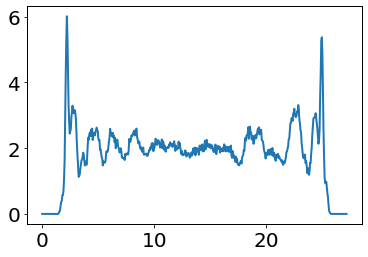

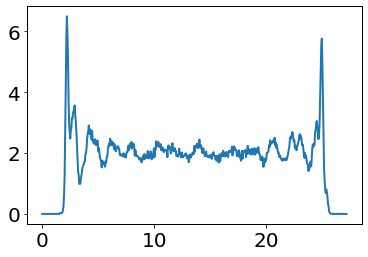

In [5]:
%%time
produnction_dir = "10.produnction"
xyz_list = ["shiftsno2-water-0.xyz", "shiftsno2-water-1.xyz", "shiftsno2-water-2.xyz", "shiftsno2-water-3.xyz"]
for idx, xyz_path in enumerate(xyz_list):
    cell = [12.745, 13.399, 40.985]
    xyz_path = os.path.join(produnction_dir, "01.water_density_DPMD", xyz_path)
    lframe = read(xyz_path, index="-1")
    lframe.set_cell(cell)
    lframe.set_pbc(True)
    surf1_Ti = anal.get_z_idx(lframe, 'Sn',4.9, 9.0)
    surf2_Ti = anal.get_z_idx(lframe, 'Sn',32.0, 35.4)
    O_idx = anal.get_z_idx(lframe, 'O', 7.7, 33.2)
    print(xyz_path)
    print(len(surf1_Ti))
    print(len(surf2_Ti))
    inp_dict={
     "functions": ["O_density"],
     "xyz_file": xyz_path,
     "cell": [12.745, 13.399, 40.985],
     "surf2": surf2_Ti,
     "surf1": surf1_Ti,
     "output": "o_density_{0:d}.dat".format(idx),
     "O_density":{
         "O_index_method": "external", 
         "O_index": O_idx
         }
     }

    tmp_traj = Analysis(inp_dict)
    tmp_traj.run()

for idx, xyz_path in enumerate(xyz_list):
    cell = [12.745, 13.399, 40.985]
    xyz_path = os.path.join(produnction_dir, "01.water_density_DPMD", xyz_path)
    lframe = read(xyz_path, index="-1")
    lframe.set_cell(cell)
    lframe.set_pbc(True)
    surf1_Ti = anal.get_z_idx(lframe, 'Sn',4.9, 9.0)
    surf2_Ti = anal.get_z_idx(lframe, 'Sn',32.0, 35.4)
    H_idx = anal.get_z_idx(lframe, 'H', 7.7, 33.2)
    print(xyz_path)
    print(len(surf1_Ti))
    print(len(surf2_Ti))
    inp_dict={
     "functions": ["O_density"],
     "xyz_file": xyz_path,
     "cell": [12.745, 13.399, 40.985],
     "surf2": surf2_Ti,
     "surf1": surf1_Ti,
     "output": "h_density_{0:d}.dat".format(idx),
     "O_density":{
         "O_index_method": "external", 
         "O_index": H_idx
         }
     }

    tmp_traj = Analysis(inp_dict)
    tmp_traj.run()
# can conclude equilibrium if density = 1 is true for 5-10 angstroms 

543
1.0050042176386504
543
0.9807859817401916
543
0.9805932171997553
543
0.9923693782155035
543
2.019856950888686
543
1.9760643521113712
543
1.976362260946591
543
2.003139008018114
CPU times: user 434 ms, sys: 56 ms, total: 490 ms
Wall time: 373 ms


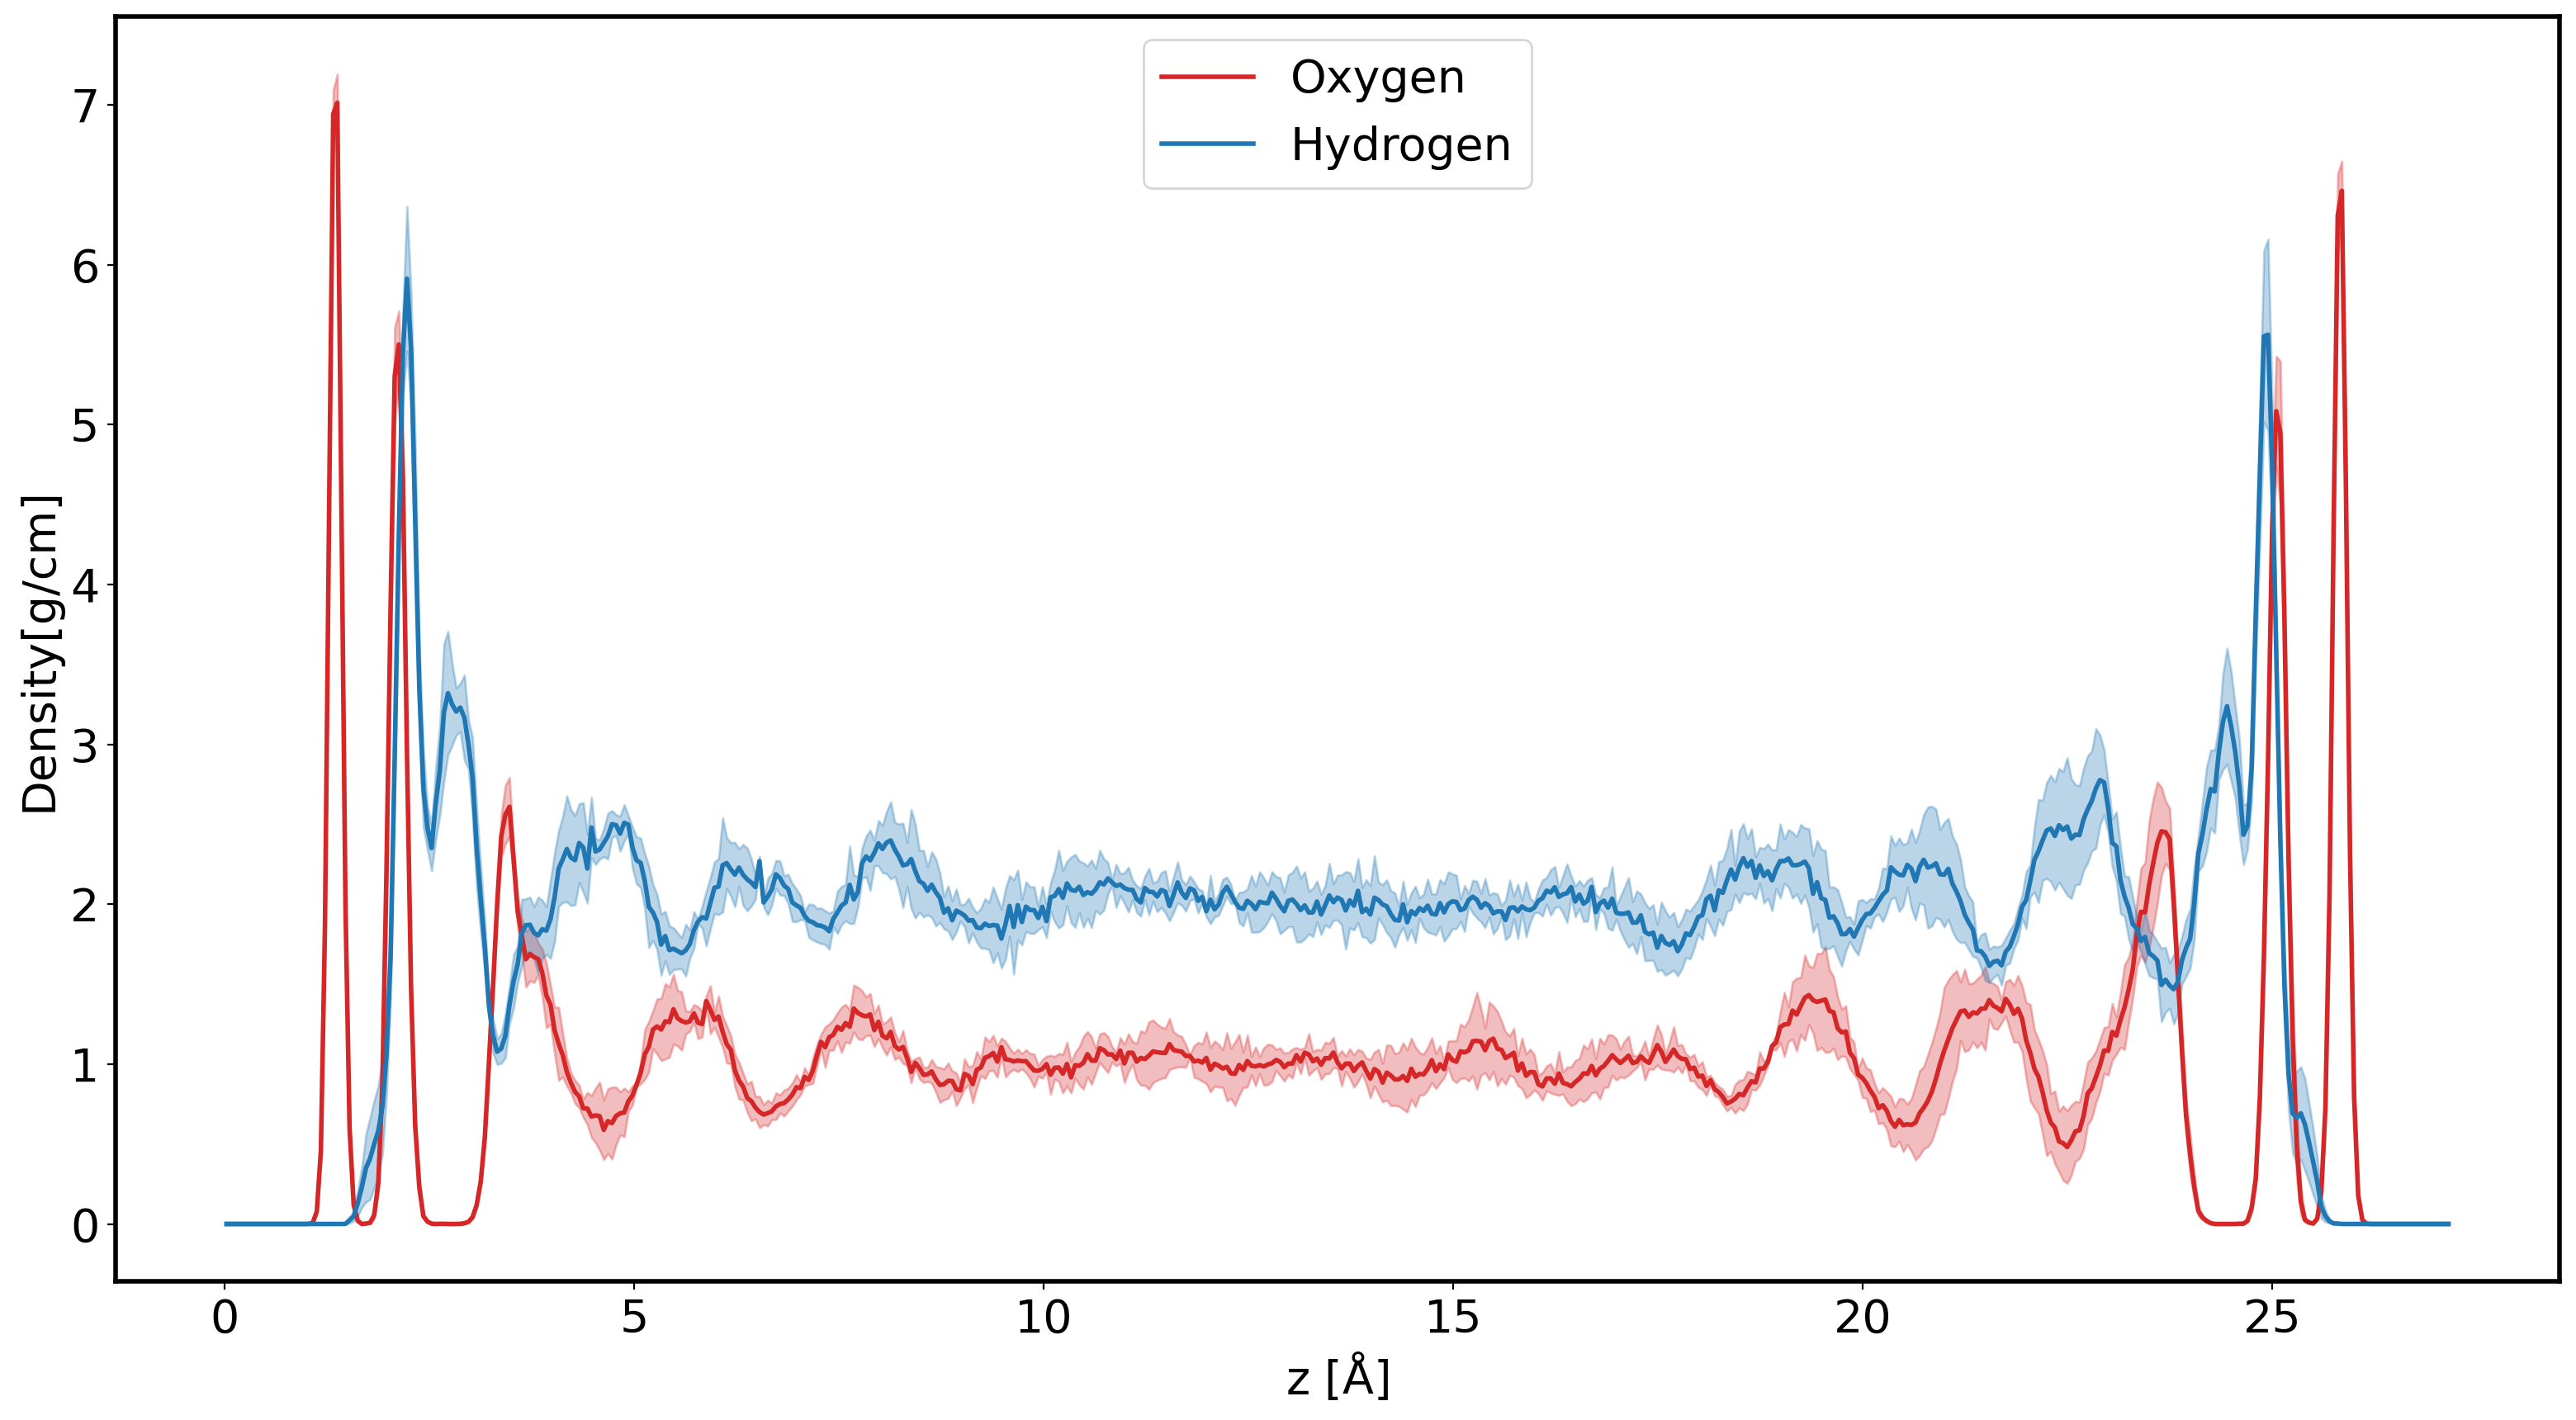

In [9]:
%%time
produnction_dir = "10.produnction"
o_den_list = ["o_density_0.dat", "o_density_1.dat", "o_density_2.dat", "o_density_3.dat"]
h_den_list = ["h_density_0.dat", "h_density_1.dat", "h_density_2.dat", "h_density_3.dat"]
o_den_list = [os.path.join(produnction_dir, "01.water_density_DPMD", o_den)  for o_den in o_den_list]
h_den_list = [os.path.join(produnction_dir, "01.water_density_DPMD", h_den)  for h_den in h_den_list]
anal.plot_water_den(o_den_list, h_den_list)

## Hartree Analysis

10.produnction/03.band_alignment/shiftSnO2-pos-1.xyz
16
16
ToolKit: The following analysis will be performed
ToolKit: Function: O_density
ToolKit: Read Structure File: 10.produnction/03.band_alignment/shiftSnO2-pos-1.xyz
ToolKit: Read the Cell Info: [12.745, 13.399, 40.985]
ToolKit: Read Surface 1 Atoms Index: [597, 602, 603, 605, 607, 614, 621, 626, 632, 634, 641, 649, 657, 665, 666, 667]
ToolKit: Read Surface 2 Atoms Index: [589, 591, 601, 615, 620, 622, 623, 627, 630, 631, 640, 643, 650, 651, 659, 668]
ToolKit: Now Start Reading Structures
ToolKit: ----------------------------
ToolKit: Reading Structures is Finished
ToolKit: Read Frame Number: 385
ToolKit: Read Atom Number: 669
ToolKit: Use the Oxygen index from external input
ToolKit: Calculated Origin Water Center Position: 20.61191098214286 A
ToolKit: Water Center will shift to Cell Center: 20.4925 A
ToolKit: START GETTING OXYGEN DENSITY
ToolKit: ----------------------------
ToolKit: Oxygen Density Profile Data Save to o_density.

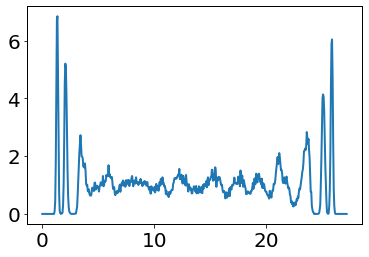

In [10]:
# long-time (1 ns) result is necessary to reach convergence
%%time
produnction_dir = "10.produnction"
cell = [12.745, 13.399, 40.985]
xyz_path = os.path.join(produnction_dir, "03.band_alignment", "shiftSnO2-pos-1.xyz")
lframe = read(xyz_path, index="-1")
lframe.set_cell(cell)
lframe.set_pbc(True)
lframe.wrap()
surf1_Sn = anal.get_z_idx(lframe, 'Sn', 4.9, 9.0)
surf2_Sn = anal.get_z_idx(lframe, 'Sn', 32.0, 35.4)
O_idx = anal.get_z_idx(lframe, 'O', 7.7, 33.2)
print(xyz_path)
print(len(surf2_Sn))
print(len(surf1_Sn))
inp_dict={
 "functions": ["O_density"],
 "xyz_file": xyz_path,
 "cell": cell,
 "surf2": surf2_Sn,
 "surf1": surf1_Sn,
 "output": "o_density.dat",
 "O_density":{
     "O_index_method": "external", 
     "O_index": O_idx
     }
 }
tmp_traj = Analysis(inp_dict)
tmp_traj.run()

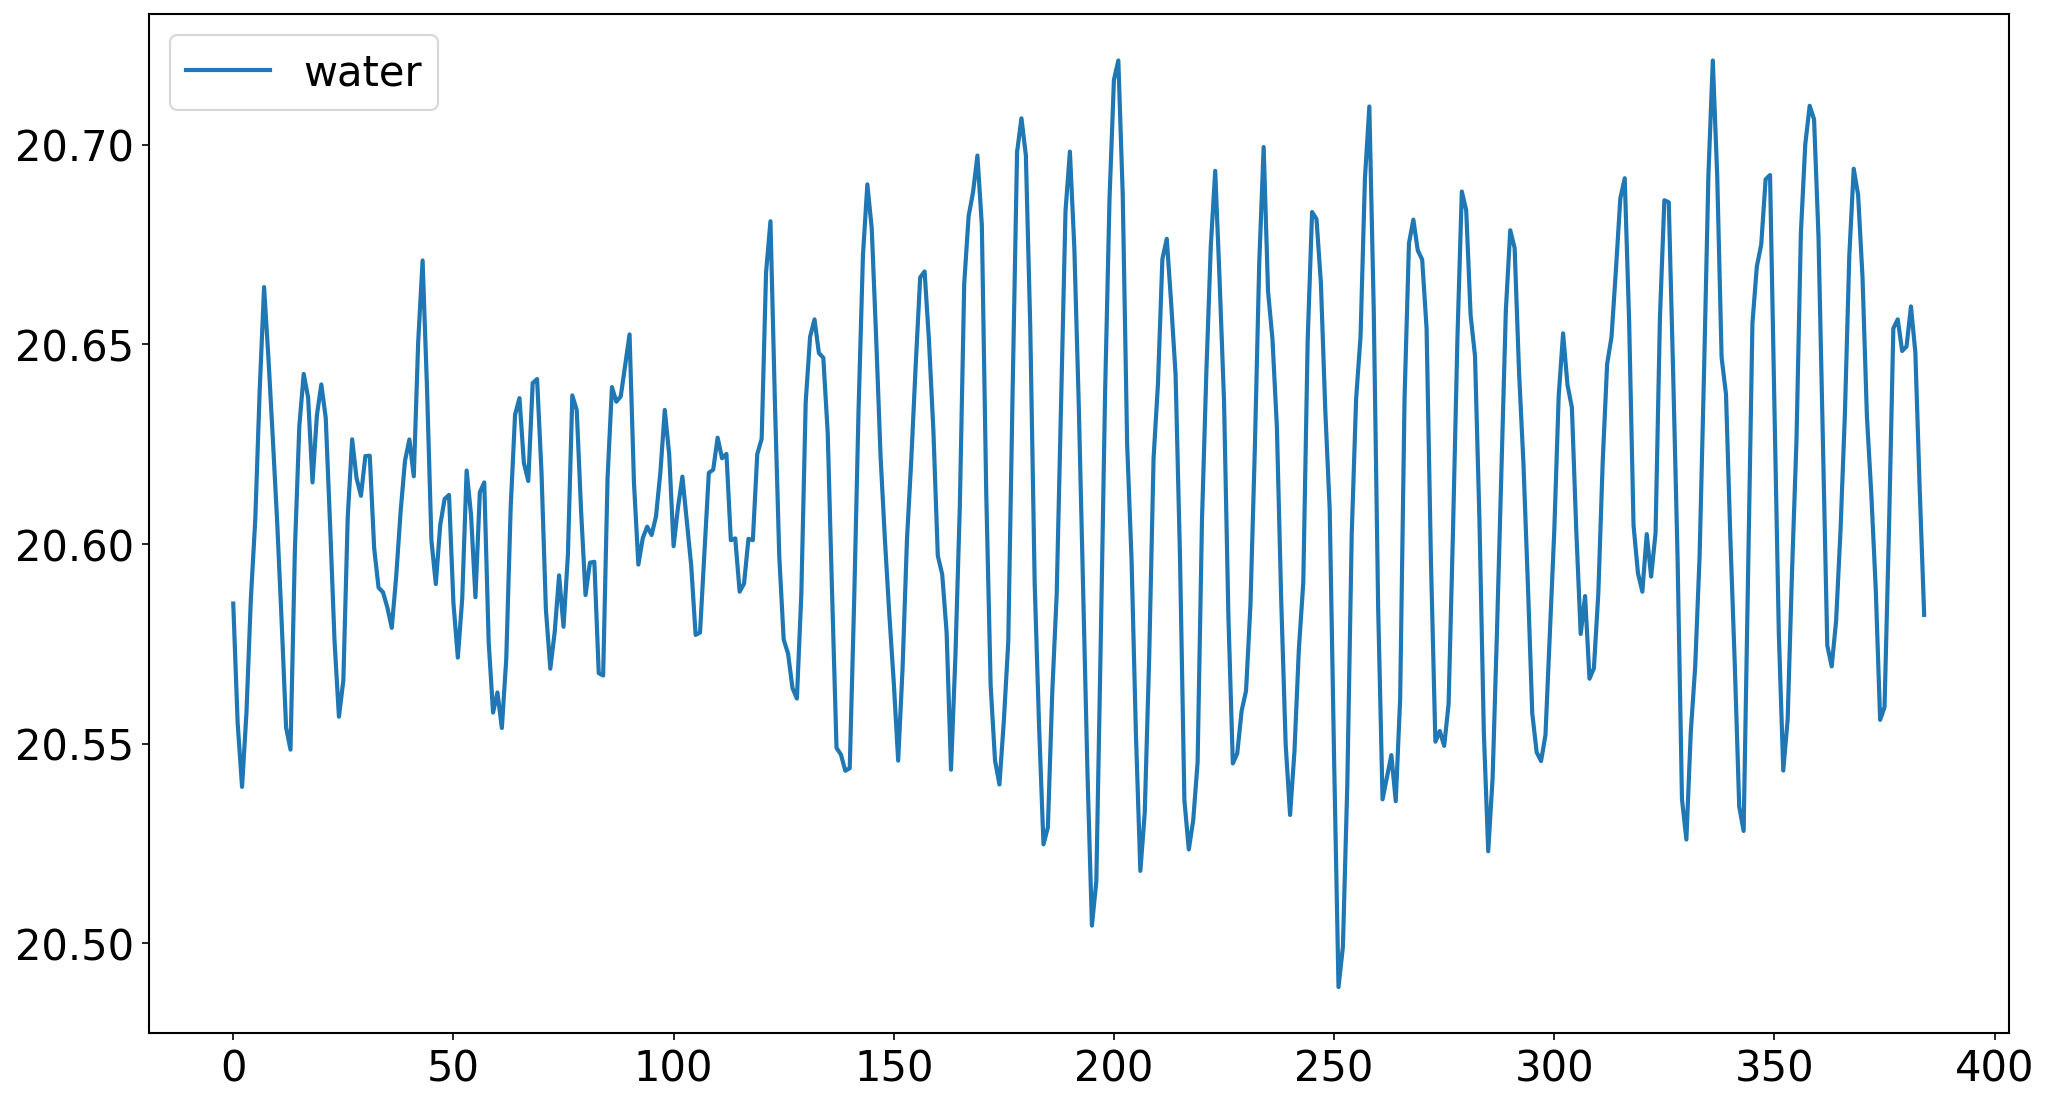

CPU times: user 379 ms, sys: 22.5 ms, total: 401 ms
Wall time: 406 ms


In [11]:
%%time
produnction_dir = "10.produnction"
os.chdir(os.path.join(produnction_dir, "03.band_alignment"))

surf1_ave_s = tmp_traj.surf1_ave_s - tmp_traj.surf1_ave_s[0]
surf2_ave_s = tmp_traj.surf2_ave_s - tmp_traj.surf2_ave_s[0]
water_cent_s = tmp_traj.water_cent_s
np.savetxt(os.path.join("water_center.dat"), water_cent_s)
plt.figure(figsize=(16,9), dpi=150, facecolor='white')
#plt.plot(surf1_ave_s)
#plt.plot(surf2_ave_s)
plt.plot(water_cent_s, label = "water")
plt.legend()
plt.show()

### Water Hartree

<img src="99.figures/hartree-water.png">

width 5 A:  3.2236568226772517
width 5.5 A:  3.2624063541678656
width 6 A:  3.3028958395299166
width 6.5 A:  3.339862001485203
width 7 A:  3.3676730174440936
width 7.5 A:  3.3831956979876163
width 8 A:  3.3886681742886813
width 8.5 A:  3.3865207205070464
width 9.0 A:  3.3845430245419372
width 9.5 A:  3.386395334677947
width 10 A:  3.387878267421659
CPU times: user 22.3 s, sys: 3.62 s, total: 25.9 s
Wall time: 28.1 s


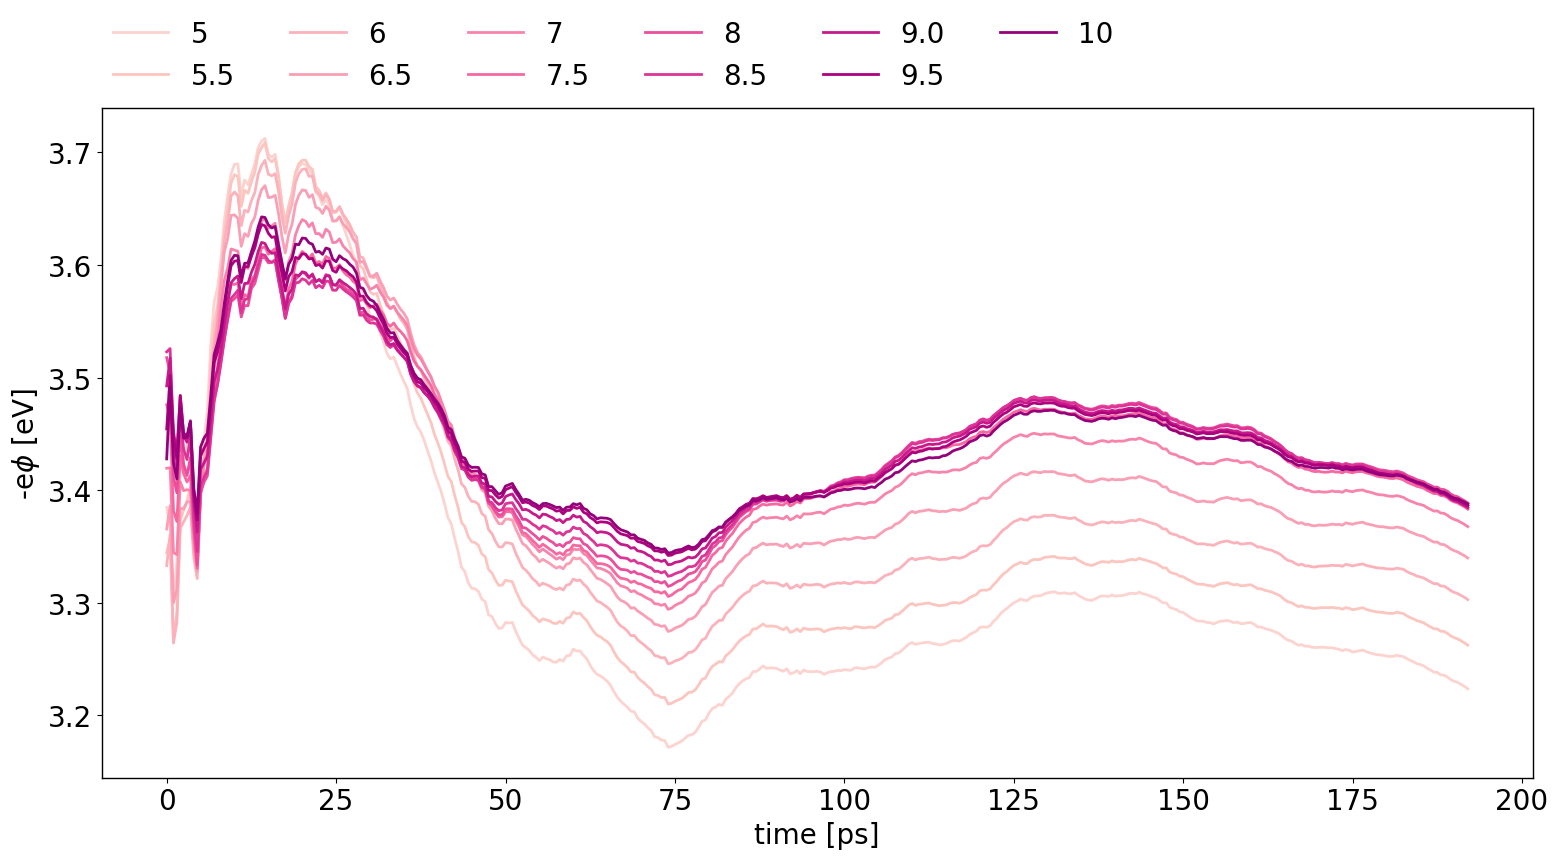

In [12]:
%%time
hartree_z = []
for i in range(1, 386):
    new_points, new_vals = cube_pav("./00.hartrees/SnO2-v_hartree-1_{0}.cube".format(i), axis="z", interpolate=False)
    hartree_z.append(new_vals)
hartree_z = np.array(hartree_z)
np.savetxt("./hartree_z.dat", hartree_z)
new_points, new_vals = cube_pav("./00.hartrees/SnO2-v_hartree-1_1.cube", axis='z',  interpolate=False)

# test hartree with different width
water_width_list = [5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9.0, 9.5, 10]

water_cent_s_shift = water_cent_s + 6.8
water_hartree = []
for j in range(len(water_cent_s_shift)):
    tmp_hartree = []
    for k in range(len(water_width_list)):
        range_idx = np.where((new_points > water_cent_s_shift[j]-water_width_list[k]/2) & (new_points < water_cent_s_shift[j]+water_width_list[k]/2))
        tmp_hartree.append(hartree_z[j][range_idx].mean())
    water_hartree.append(tmp_hartree)
water_hartree = np.array(water_hartree)
water_hartree = water_hartree.T

header = ' '
for i in water_width_list:
    header += str(i) + '[A] '
np.savetxt("./water-hartree.dat", water_hartree.T, header=header )
np.savetxt("./water-width.dat", water_width_list)
colorlist = anal.cmap2colorlist('RdPu', 13)
fig, ax = plt.subplots(figsize=(16,9), dpi=100, facecolor='white')
for k in range(len(water_width_list)):
    ax.plot(np.arange(0, len(water_hartree[k]))*0.5, anal.cumave(water_hartree[k]), label=str(water_width_list[k]), color=colorlist[k])
    print("width", water_width_list[k], "A: ", anal.cumave(water_hartree[k])[-1])
ax.set_ylabel(r"-e$\phi$ [eV]")
ax.set_xlabel("time [ps]")
ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=6,
            borderaxespad=0, frameon=False)
fig.tight_layout()
fig.savefig("Hartree_equilibrium.pdf")


<img src="99.figures/hartree-bulk.png">

16
16
16
-3.8529823533784824
-3.8284111913763974
-3.8024824649701743
CPU times: user 1.34 s, sys: 112 ms, total: 1.46 s
Wall time: 1.4 s


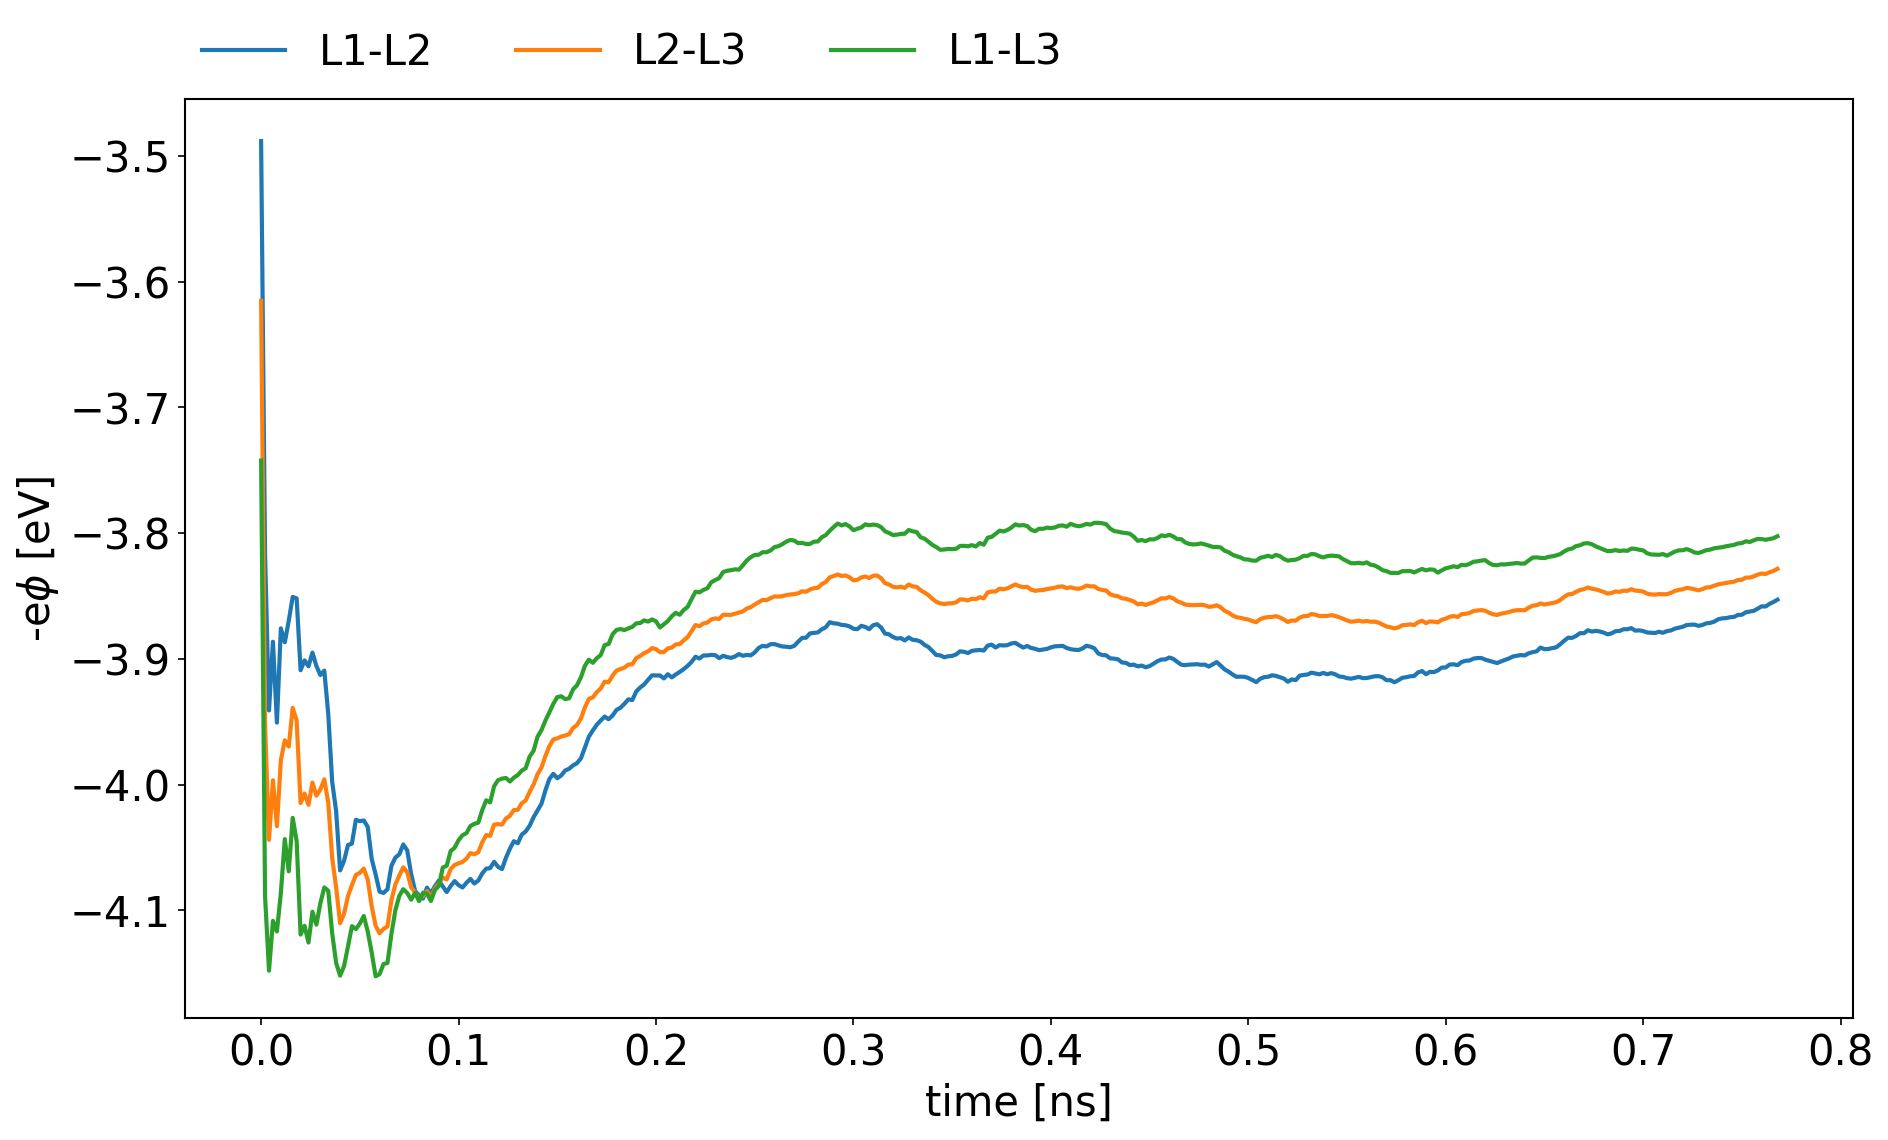

In [13]:
%%time
xyz_list = ["SnO2-pos-1.xyz"]
cell = [12.745, 13.399, 40.985]

lframe = read(xyz_list[0], index="-1")
lframe.set_cell(cell)
lframe.set_pbc(True)
bulk_Sn_1_idx = anal.get_z_idx(lframe, 'Sn', 2.8, 3.8)
bulk_Sn_2_idx = anal.get_z_idx(lframe, 'Sn', 6.3, 7.3)
bulk_Sn_3_idx = anal.get_z_idx(lframe, 'Sn', 10, 11)

print(len(bulk_Sn_1_idx))
print(len(bulk_Sn_2_idx))
print(len(bulk_Sn_3_idx))

bulk_Sn_1_z_list = []
bulk_Sn_2_z_list = []
bulk_Sn_3_z_list = []
frames = read(xyz_list[0], index=":")
for frame in frames:
    frame.set_cell(cell)
    frame.set_pbc(True)
    z_list = frame.get_positions().T[2]
    bulk_Sn_1_z_list.append(z_list[bulk_Sn_1_idx].mean())
    bulk_Sn_2_z_list.append(z_list[bulk_Sn_2_idx].mean())
    bulk_Sn_3_z_list.append(z_list[bulk_Sn_3_idx].mean())

hartree_z = np.loadtxt("./hartree_z.dat")
new_points, new_vals = cube_pav("./00.hartrees/SnO2-v_hartree-1_1.cube", axis='z',  interpolate=False)

def save_bulk_hartree(z_list_1, z_list_2, idx):
    bulk_hartree = []
    for j in range(len(z_list_1)):
        tmp_hartree = []
        for k in range(1):
            range_idx = np.where((new_points > z_list_1[j]) & (new_points < z_list_2[j]))
            tmp_hartree.append(hartree_z[j][range_idx].mean())
        bulk_hartree.append(tmp_hartree)
    bulk_hartree = np.array(bulk_hartree)
    bulk_hartree = bulk_hartree.T
    header = ' '
    np.savetxt("./bulk-hartree-{0:d}.dat".format(idx), bulk_hartree.T, header=header )
save_bulk_hartree(bulk_Sn_1_z_list, bulk_Sn_2_z_list, idx=0)
save_bulk_hartree(bulk_Sn_1_z_list, bulk_Sn_3_z_list, idx=1)
save_bulk_hartree(bulk_Sn_2_z_list, bulk_Sn_3_z_list, idx=2)

label_list = ["L1-L2", "L2-L3", "L1-L3"]
fig, ax = plt.subplots(figsize=(13,8),dpi=150, facecolor="white")
for k in range(3):
    bulk_hartree = np.loadtxt("bulk-hartree-{0}.dat".format(k))
    print(anal.cumave(bulk_hartree)[-1])
    ax.plot(np.arange(0, len(bulk_hartree))*0.002, anal.cumave(bulk_hartree), label=label_list[k], color="C{0}".format(k))
ax.set_ylabel(r"-e$\phi$ [eV]")
ax.set_xlabel("time [ns]")
ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=6,
            borderaxespad=0, frameon=False)
fig.tight_layout()
fig.savefig("Hartree_equilibrium_bulk.pdf")

## Band Alignment

$$eU_{VBM/CBM} = -E_{VBM/CBM}^{(b)} - e(\phi_{wat}^{(i)} - \phi_{bulk}^{(i)}) +\Delta_{DP} A_{H_3O^+}^{(w)} - \mu _{H^+}^{(g,o)} -\Delta E_{ZP} $$

In [14]:
vbm = -0.182856*au2eV  + 3.38 - (-3.8) + 15.35 - 15.81 - 0.35
cbm = -0.222597*au2eV  + 3.38 - (-3.8) + 15.35 - 15.81 - 0.35

In [15]:
print(vbm)
print(cbm)

1.3942347566036193
0.3128270558018077


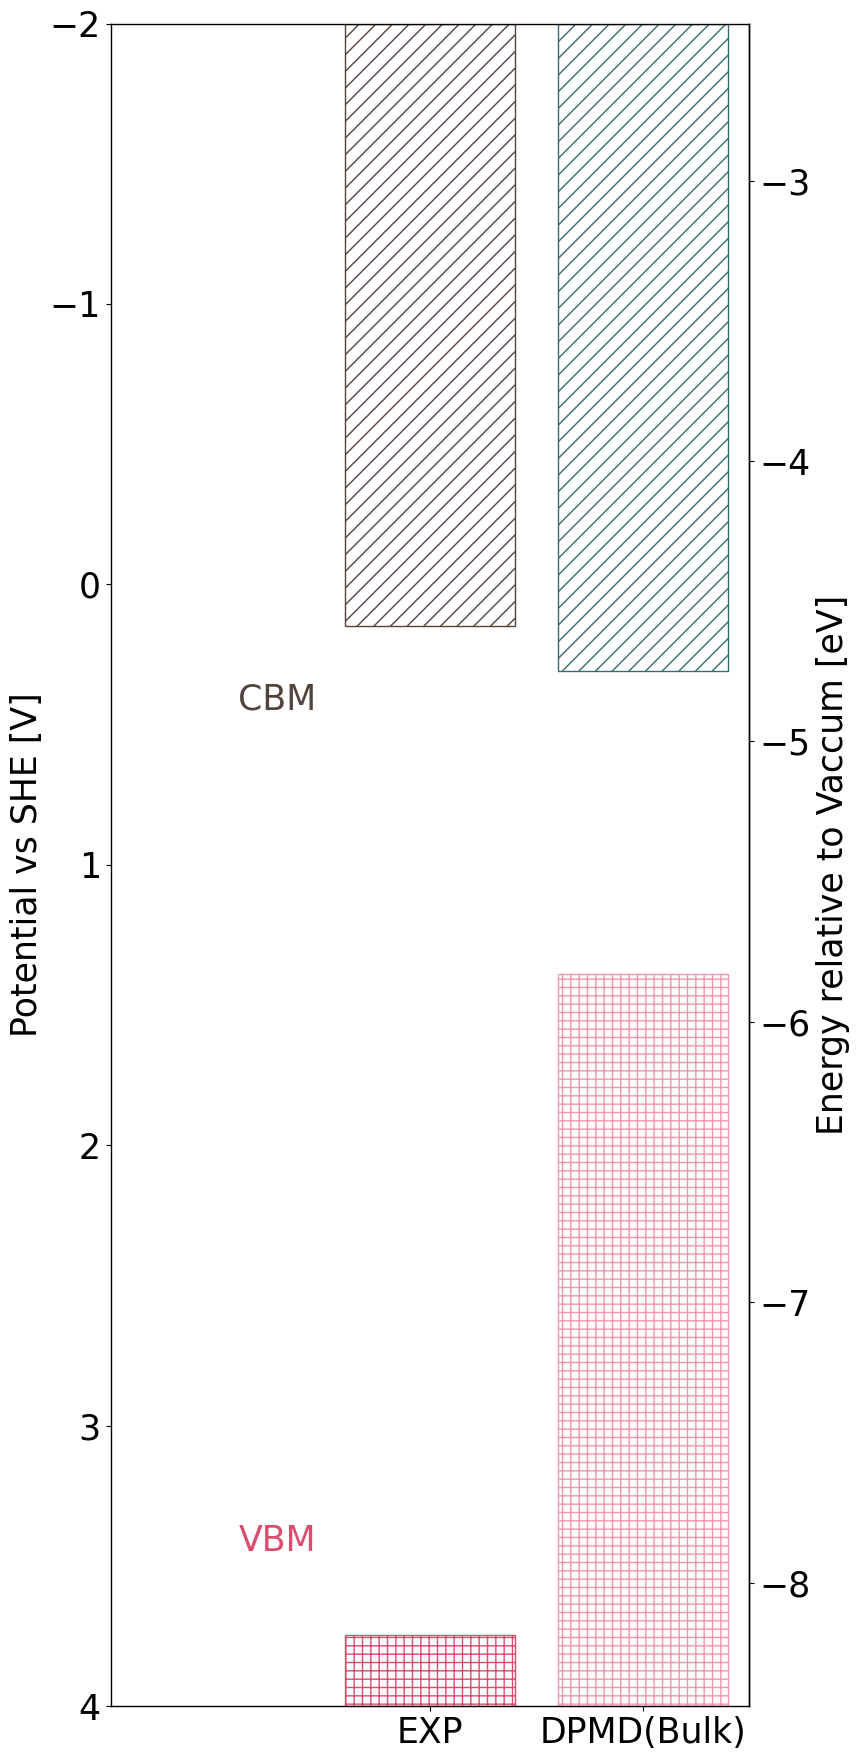

In [16]:
sys = ["EXP", "DPMD(Bulk)"]
vbm = [3.747, 1.39]
vbm = np.array(vbm)
cbm = [0.147, 0.31]
cbm = np.array(cbm)

anal.plot_band_align(cbm, vbm, sys)